In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import surrogate1 as sr1
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
L63_data_path = '../data/L63-trajectories'
save_folder = '../data/nn_adaptive_lr_s'
D_r, N = 300, 20000
L0, L1 = 0.4, 3.5 
beta = 4e-5
train = np.load(f'{L63_data_path}/train.npy')[:, :N].astype(np.float64)
test = np.load(f'{L63_data_path}/test.npy')[:500, :, :330].astype(np.float64)
model = srnn.SurrogateModel_NN(3, 300, save_folder=save_folder)
model.load(1499000)
# model.init_with_rf(L0, L1, beta, train, [D_r, 0, 0])
idx = lambda x: ~np.isnan(x)
W_in = model.net[0].weight.detach().numpy()
b_in = model.net[0].bias.detach().numpy()
Wb = np.hstack([W_in, b_in.reshape(-1, 1)])
pre_phi = lambda x: Wb @ np.hstack([x, 1])
max = lambda x: 0 if len(x) < 1 else np.max(x)
def part_phi(y):
    y = np.abs(y)
    good = y[(y>0.4) & (y<3.5)]
    linear = y[y<=0.4]
    saturated = y[y>=3.5]
    return np.array([len(good), len(linear), len(saturated)]), np.array([np.linalg.norm(good), np.linalg.norm(linear), np.linalg.norm(saturated)]),\
    np.array([max(good), max(linear), max(saturated)])


def part_phi_t(y, n):
    gls = np.zeros((n, 3))
    norms = np.zeros((n, 3))
    maxs = np.zeros((n, 3))
    for i in range(n):
        if i == 0:
            v = y
        else:
            v = model.forecast(v)
        gls[i, :], norms[i, :], maxs[i, :] = part_phi(pre_phi(v))
        
    return gls, norms, maxs

def phi_evol(data, n):
    gls = np.zeros((len(data), n, 3))
    norms = np.zeros((len(data), n, 3))
    maxs = np.zeros((len(data), n, 3))
    for i, y in enumerate(data):
        gls[i], norms[i], maxs[i] = part_phi_t(y, n)
    np.save(f'{save_folder}/gls.npy', gls)
    np.save(f'{save_folder}/norms.npy', norms)
    np.save(f'{save_folder}/maxs.npy', maxs)
    return gls, norms, maxs


In [3]:
p=5
phi_evol(test[:, :, 0], 330);

gls = np.load(f'{save_folder}/gls.npy')
mgls = np.average(gls, axis=0)
tau = model.compute_tau_f_(test[p:p+1])[1]
tau

Time taken by compute_tau_f_ is 0.0056 seconds


array([3.9676])

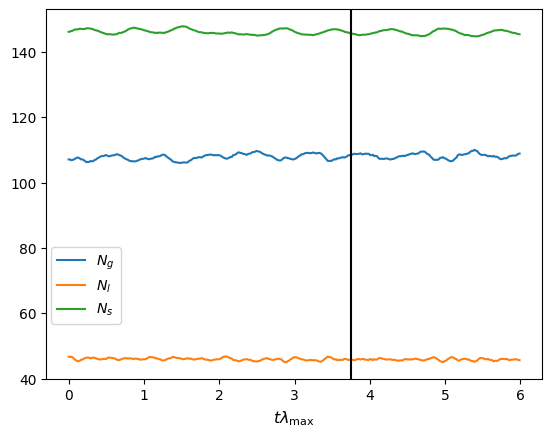

In [20]:
t = np.arange(330)*0.02*0.91
plt.plot(t, mgls[:, 0], label=r'$N_g$')
plt.plot(t, mgls[:, 1], label=r'$N_l$')
plt.plot(t, mgls[:, 2], label=r'$N_s$')
plt.axvline(3.75, c='black')#, label=r'$\tau_f=3.75$')
plt.xlabel('$t\lambda_{\max}$', fontsize=11.5)
# plt.title('How features produced by a trained NN evolve in time as you keep recursing')
plt.legend(loc=(0.01, 0.15), fontsize=10.2)
# plt.xlim((0, 7.5))
plt.savefig('../data/plots/nn-feature-evol-all.png')

In [184]:
W_in

array([[ 2.16780394e-04,  6.97883394e-04,  6.92496468e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.63026611e-03, -4.07235012e-03,  3.85539657e-03],
       [ 1.01396686e-04,  2.57552454e-04, -8.26659711e-06],
       [-5.34495981e-03,  1.69810706e-03, -8.46804303e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.95063704e-03, -8.83153043e-05, -5.64553178e-03],
       [-4.03222264e-04,  1.90783057e-03,  1.24647549e-03],
       [-9.61596982e-03, -3.02676460e-02,  2.78288976e-03],
       [ 3.85063346e-04,  4.86344600e-04,  5.43533474e-04],
       [ 1.11703433e-02,  7.69958593e-03, -7.48368809e-03],
       [ 9.15340888e-04,  6.32160668e-04, -1.20028307e-03],
       [ 3.55434337e-04,  1.55303457e-03,  1.00580590e-03],
       [ 5.60496593e-05, -7.91959002e-06, -6.68087331e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.64864939e-03, -2.66879209e-02

In [141]:
model.forecast(test[2:3, :, 0])

array([[-3.58296427, -6.26058774, 12.51325851]])

In [205]:
107, 45, (300-107-45)

(107, 45, 148)